In [2]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

# 加载环境变量
load_dotenv(override=False)  # override=False 避免.env覆盖系统环境变量

llm = ChatOpenAI(
    model=os.getenv("MODEL_NAME"),
    temperature=0.5,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url=os.getenv("BASE_URL")
)

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

In [4]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

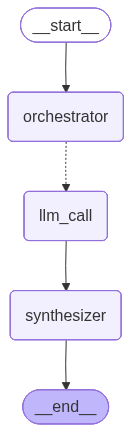

## Introduction to LLM Scaling Laws

Large Language Models (LLMs) are a class of artificial intelligence models characterized by their vast number of parameters, typically ranging from billions to trillions, and their ability to process and generate human-like text. These models are trained on enormous datasets of text and code, enabling them to perform a wide array of natural language processing (NLP) tasks such as translation, summarization, question answering, and creative content generation.

Scaling laws, in the context of LLMs, describe the empirical relationships between a model's performance and the resources invested in its development. These resources primarily include the number of model parameters, the size of the training dataset, and the amount of computational power (compute) used during training. The core concept is that as these resources increase, the model's performance on various benchmarks tends to improve in a predictable, power-law fashion. This means that with more data, more parameters, or more compute, LLMs generally become more capable, exhibiting improved accuracy, fluency, and generalization abilities.

The significance of scaling laws for LLM development and optimization cannot be overstated. They provide a fundamental understanding of how to effectively allocate resources to build more powerful and efficient models. By quantifying the impact of increased resources, scaling laws guide researchers and engineers in designing training strategies, predicting model capabilities, and making informed decisions about infrastructure investments. They have been instrumental in the rapid advancements observed in the field of LLMs, enabling the development of increasingly sophisticated models by providing a roadmap for continued performance gains through strategic scaling.

---

## Historical Context and Early Observations

The phenomenon of scaling in neural networks, particularly the observation that increased model size, data, and compute generally lead to improved performance, has been a topic of growing interest. Early observations of this trend were largely empirical, with researchers noting that larger models often achieved better results on various tasks. However, it was the seminal work by Kaplan et al. (2020), "Scaling Laws for Neural Language Models," that provided a foundational and quantitative understanding of these relationships, specifically for large language models (LLMs).

Kaplan et al. (2020) systematically investigated the relationship between model performance (measured by cross-entropy loss), model size (number of parameters), dataset size (number of tokens), and compute budget (FLOPs). Their key finding was the demonstration of a **power-law relationship** between these factors and performance. They showed that as model size, dataset size, or compute budget increased, the loss decreased predictably according to a power law. This implied that performance improvements were not just incremental but followed a consistent mathematical curve, suggesting a fundamental property of how these models learn. They also observed that there were diminishing returns for each factor in isolation, but that optimal performance was achieved by scaling all three factors in concert.

Building upon this foundation, Hoffmann et al. (2022) further refined and extended these scaling laws in their work, "Training Compute-Optimal Large Language Models." This research focused on the **compute-optimal allocation of model size and training data**, a crucial practical consideration for training LLMs efficiently. Hoffmann et al. analyzed a broader range of models and training regimes, confirming the power-law relationship and providing more precise coefficients. A significant contribution was their finding that, for a given compute budget, models were often *undertrained* relative to their size in previous research. They proposed that optimal performance for a given compute budget is achieved when both model size and the number of training tokens are scaled roughly proportionally. Specifically, they suggested that for every parameter, approximately 20 tokens should be trained. This finding had profound implications for the design and training strategies of subsequent LLMs, emphasizing the importance of balancing model capacity with the amount of data it is exposed to during training.

These early works established the empirical basis for understanding scaling in LLMs, demonstrating that performance gains are not arbitrary but follow predictable power laws. They shifted the paradigm from heuristic model development to a more principled, data-driven approach to designing and training increasingly capable language models. The identification of these scaling laws provided a roadmap for future research and development, guiding the construction of models like GPT-3 and beyond.

---

### Key Factors in LLM Scaling

The performance and capabilities of Large Language Models (LLMs) are profoundly influenced by three primary scaling factors: the number of model parameters (N), the size of the training data (D), and the computational budget (C). Understanding how these factors interact and contribute to model improvement is crucial for advancing LLM development.

**1. Model Parameters (N):**
This refers to the number of weights and biases within the neural network architecture. Increasing N generally allows the model to learn more complex patterns and store a greater amount of knowledge. Larger models possess higher capacity, enabling them to capture finer-grained linguistic nuances, improve factual recall, and generate more coherent and contextually relevant text. However, increasing N also leads to higher memory requirements during training and inference, and can exacerbate issues like overfitting if not balanced with sufficient training data.

**2. Training Data Size (D):**
D represents the quantity and diversity of the text used to train the LLM. A larger and more diverse dataset exposes the model to a wider range of linguistic phenomena, factual information, and stylistic variations. This helps the model generalize better, reduce biases present in smaller datasets, and improve its ability to perform various tasks. Insufficient data for a given model size can lead to underfitting or the model failing to fully utilize its capacity. The quality of the data is as important as its quantity; noisy or irrelevant data can hinder performance despite large D.

**3. Computational Budget (C):**
C encompasses the total computational resources (e.g., GPU hours, energy consumption) expended during the training process. A larger computational budget allows for longer training times, more extensive hyperparameter tuning, and the ability to train larger models on larger datasets. It directly influences the ability to iterate on model architectures, optimize training procedures, and ultimately achieve better performance. Constraints on C often necessitate trade-offs between N and D, or between model performance and development cost.

**Independent and Interactive Influences:**

While each factor independently contributes to LLM performance, their interaction is critical.

*   **N and D:** A large model (high N) trained on a small dataset (low D) may overfit, memorizing the training data rather than learning generalizable patterns. Conversely, a small model (low N) trained on a vast dataset (high D) may underfit, unable to fully leverage the information available. Optimal performance often requires a balanced scaling of N and D, where the model's capacity matches the complexity and volume of the training data.
*   **N and C:** Training larger models (high N) inherently requires a larger computational budget (high C). If C is limited, it constrains the maximum achievable N. Efficient model architectures and training algorithms can help maximize the effective N for a given C.
*   **D and C:** Training on larger datasets (high D) also demands a larger computational budget (high C) due to the increased number of training steps. Data preprocessing and efficient data loading strategies become crucial to optimize the use of C when D is very large.

**Optimal Scaling Regimes:**

The concept of 'optimal' scaling regimes refers to the discovery that there exist specific relationships between N, D, and C that yield the most efficient improvements in LLM performance. Early research often focused on scaling one factor at a time. However, more recent work, such as the Chinchilla scaling laws, suggests that for a given computational budget (C), there is an optimal balance between the number of parameters (N) and the amount of training data (D). These laws indicate that previous LLMs were often "undertrained" for their size, meaning they had too many parameters relative to the amount of data they were trained on. The Chinchilla optimal scaling suggests that for a fixed compute budget, one should scale both N and D proportionally, rather than disproportionately favoring N. Adhering to these optimal scaling laws allows researchers to achieve better performance for a given computational cost, or to reach a target performance level with fewer resources. These regimes are dynamic and continue to be refined as new architectures and training techniques emerge.

---

### Mathematical Formulations of Scaling Laws

Scaling laws are frequently characterized by mathematical models, most notably power laws, which describe how a system's output or performance changes with respect to an input or resource. The general form of a power law is:

$Y = aX^b$

where:
*   $Y$ represents the dependent variable (e.g., model performance, training time, or number of parameters).
*   $X$ represents the independent variable (e.g., dataset size, model size, or computational budget).
*   $a$ is a constant multiplier or scaling factor, often reflecting the baseline performance or efficiency.
*   $b$ is the scaling exponent, which dictates the rate at which $Y$ changes with $X$.

In the context of machine learning, particularly large language models, several specific scaling relationships are observed:

1.  **Performance Scaling with Data Size:**
    $L \propto N^{-\alpha_N}$
    Here, $L$ denotes the loss (e.g., perplexity or error rate), and $N$ is the number of training tokens. The exponent $\alpha_N$ typically falls between 0.03 and 0.07, indicating that increasing data size leads to a reduction in loss, albeit with diminishing returns.

2.  **Performance Scaling with Model Size (Parameters):**
    $L \propto P^{-\alpha_P}$
    In this formulation, $P$ represents the number of model parameters. The exponent $\alpha_P$ is often found to be around 0.05 to 0.07, suggesting that larger models generally achieve lower loss.

3.  **Performance Scaling with Compute Budget:**
    $L \propto C^{-\alpha_C}$
    Here, $C$ represents the computational budget, often measured in FLOPs (floating-point operations). Since compute is often a function of both model size and training steps, this can be a more comprehensive metric. The exponent $\alpha_C$ is typically observed to be around 0.05 to 0.07.

4.  **Combined Scaling Laws (Chinchilla-style):**
    More sophisticated models integrate multiple factors. For instance, the Chinchilla optimal scaling laws suggest that for a given compute budget $C$, the optimal number of parameters $P$ and training tokens $N$ are related. The loss $L$ can be modeled as:
    $L(N, P) = E_0 + \frac{A}{N^{\alpha_N}} + \frac{B}{P^{\alpha_P}}$
    where $E_0$ is the irreducible loss, and $A$ and $B$ are constants. The exponents $\alpha_N$ and $\alpha_P$ are empirically determined. For a fixed compute budget, there's an optimal balance between $N$ and $P$.

**Derivation and Validation:**

These equations are primarily derived through empirical observation and statistical fitting. Researchers conduct extensive experiments where they systematically vary one or more independent variables (e.g., dataset size, model parameters, training steps) while keeping others constant. The resulting performance metrics (e.g., test loss, accuracy) are then plotted against the varied input, often on a log-log scale. If the relationship is a power law, the data points will align along a straight line on a log-log plot, and the slope of this line directly corresponds to the scaling exponent $b$.

The process involves:
1.  **Experimental Design:** Carefully designing experiments to isolate the effect of specific variables.
2.  **Data Collection:** Training numerous models across a wide range of input values.
3.  **Log-Log Plotting:** Visualizing the data on a log-log scale to identify linear relationships.
4.  **Regression Analysis:** Using linear regression (on the log-transformed data) to estimate the scaling exponent ($b$) and the constant multiplier ($a$).
5.  **Cross-Validation and Replication:** Validating the derived laws across different model architectures, tasks, and datasets to ensure their generality and robustness.

For example, the original "Scaling Laws for Neural Language Models" by Kaplan et al. (2020) systematically varied model size, dataset size, and computational budget, demonstrating the power-law relationships between these factors and model performance. Subsequent works, like "Chinchilla's optimal training compute" by Hoffmann et al. (2022), further refined these laws by exploring the optimal balance between parameters and data for a given compute budget, leading to more efficient training strategies. These empirical studies provide strong evidence for the validity and predictive power of these mathematical formulations in understanding and guiding the development of large-scale AI systems.

---

## Implications and Applications of Scaling Laws

Scaling laws provide a powerful framework for understanding and predicting the behavior of large language models (LLMs) as they grow in size, data, and computational resources. Their practical implications are far-reaching, fundamentally shaping decisions across the entire LLM lifecycle, from initial design to deployment and ongoing optimization.

**Informing Resource Allocation:** Scaling laws directly guide the strategic allocation of computational resources. By understanding the power-law relationships between model performance and factors like parameter count, dataset size, and training FLOPs, developers can make informed trade-offs. For instance, if a scaling law suggests diminishing returns for increasing parameter count beyond a certain point, resources might be better allocated to acquiring more diverse and higher-quality training data. Conversely, if a model is data-constrained, prioritizing data acquisition and processing infrastructure becomes paramount. This allows for more efficient use of expensive GPU clusters and reduces wasted computational effort on configurations that yield minimal performance gains.

**Guiding Model Architecture and Training Strategies:** Scaling laws influence architectural design choices and training methodologies. They highlight the importance of architectures that can efficiently scale, such as the transformer architecture, which has demonstrated impressive scaling properties. Furthermore, scaling laws can inform decisions about hyperparameter tuning, such as optimal learning rates and batch sizes, by suggesting how these parameters might need to adjust as models scale. For example, some research indicates that optimal learning rates may scale inversely with batch size, a relationship that can be exploited to maintain training stability and efficiency across different scales. They also emphasize the critical role of data quality and diversity, as scaling laws often show that performance gains from data are as significant, if not more so, than those from model size alone. This encourages investment in robust data curation and augmentation pipelines.

**Examples of Successful LLM Development Guided by Scaling Laws:**

*   **GPT-3 (OpenAI):** The development of GPT-3 is a prime example of scaling laws in action. OpenAI systematically explored the relationship between model size, dataset size, and training compute, demonstrating that simply scaling up existing architectures with more data and compute led to unprecedented capabilities. Their research on scaling laws directly informed the decision to train a 175-billion parameter model, leading to its remarkable few-shot learning abilities.
*   **Chinchilla (DeepMind):** DeepMind's Chinchilla model explicitly challenged the prevailing wisdom that larger models were always better, demonstrating that for a given compute budget, smaller models trained on significantly more data could outperform much larger models trained on less data. This finding, derived from extensive scaling law analysis, led to a more compute-efficient and performant model, highlighting the importance of balancing model size and data.
*   **PaLM (Google):** Google's Pathways Language Model (PaLM) also leveraged insights from scaling laws to achieve its impressive performance. By understanding how different scaling dimensions (model size, data size, and training steps) interact, Google was able to optimize the training process for a 540-billion parameter model, achieving state-of-the-art results across numerous benchmarks.

In essence, scaling laws transform the development of LLMs from an empirical art into a more principled engineering discipline. By providing a predictive framework, they enable researchers and engineers to make more strategic, data-driven decisions, ultimately accelerating the progress and enhancing the capabilities of cutting-edge language models.

---

## Limitations and Challenges

Current scaling laws, while powerful, face several limitations that hinder their universal applicability and predictive accuracy. A primary concern is their generalizability across diverse tasks, model architectures, and data distributions. While robust scaling relationships have been observed in large language models for tasks like text generation and question answering, their effectiveness can diminish significantly when applied to highly specialized domains (e.g., scientific discovery, medical diagnosis) or tasks requiring complex reasoning beyond pattern recognition. Similarly, scaling laws derived for transformer-based architectures may not directly translate to other model types, such as recurrent neural networks or graph neural networks, which exhibit different computational properties and learning dynamics. The impact of data distribution shifts is also a critical challenge; models trained on one data distribution may not scale predictably when exposed to significantly different or out-of-distribution data, potentially leading to performance plateaus or even degradation.

Another significant challenge is the phenomenon of diminishing returns. As models and datasets grow, the marginal performance gains per unit of additional compute or data tend to decrease. This implies that simply throwing more resources at a problem will eventually yield diminishing improvements, making it difficult to justify the escalating computational cost. The sheer computational expense associated with training and experimenting with increasingly larger models is a major barrier, limiting the ability of many researchers and organizations to explore the upper bounds of scaling. This cost extends beyond training, encompassing inference, storage, and energy consumption, raising sustainability concerns.

The "irreducible loss" problem, or the existence of a fundamental lower bound on achievable error, also presents a limitation. While scaling laws often predict a continuous decrease in loss with increased scale, there may be inherent noise, ambiguity, or incompleteness in the data that prevents perfect prediction, regardless of model size. This irreducible loss can manifest as a plateau in performance, even with continued scaling, suggesting that factors beyond model capacity become dominant.

Furthermore, current scaling laws may not fully capture the complex emergent behaviors observed in very large models. Phenomena like in-context learning, tool use, and complex reasoning abilities often appear non-linearly and are not always directly predicted by simple power-law relationships between scale and performance. The interplay between model architecture, training data quality, and optimization strategies can lead to synergistic effects that are difficult to model with current scaling frameworks. The impact of fine-tuning, prompt engineering, and human feedback on model performance, which can significantly alter a model's capabilities, is also not typically accounted for in foundational scaling laws. These areas represent gaps in our understanding where more sophisticated theoretical and empirical frameworks are needed to fully characterize the scaling landscape.

---

## Future Directions and Open Questions

Research into LLM scaling laws is a rapidly evolving field, with numerous avenues for future exploration and a wealth of open questions. A primary area of ongoing investigation involves exploring **new scaling dimensions** beyond the traditional parameters of model size (N), dataset size (D), and compute (C). This includes examining the impact of architectural choices (e.g., mixture-of-experts, novel attention mechanisms), training time and optimization strategies, data quality and diversity, and even the role of human feedback and alignment techniques on model performance and scaling. Understanding how these factors interact and contribute to overall capabilities is crucial for developing more comprehensive scaling theories.

Another critical direction is the deeper investigation into **emergent capabilities**. While current scaling laws effectively predict performance on established benchmarks, they offer limited insight into the sudden appearance of complex reasoning, problem-solving, or creative abilities as models scale. Future research aims to quantify and predict the emergence of these capabilities, exploring whether they are a direct consequence of increased scale or if other factors, such as specific architectural inductive biases or training objectives, play a more significant role. This also involves developing new metrics and evaluation paradigms that can robustly assess these emergent properties.

The development of **more generalized or nuanced scaling theories** is also a key objective. Current power-law scaling often holds within specific regimes but may break down or require modification under different conditions. Future work will focus on developing theories that account for non-linearities, phase transitions, and the interplay between various scaling dimensions. This includes exploring whether there are fundamental limits to scaling, and if so, what those limits are and how they might be overcome. Furthermore, understanding the theoretical underpinnings of why power laws emerge in LLM scaling is an active area of research, potentially drawing insights from statistical physics, information theory, and complexity science.

Several **open questions** remain at the forefront of LLM scaling research:

*   **What are the fundamental limits of scaling?** Is there a point beyond which further increases in N, D, or C yield diminishing returns, or even negative consequences?
*   **Can we develop a unified scaling theory that encompasses all relevant dimensions and emergent behaviors?** How can we integrate architectural innovations, data quality, and training dynamics into a cohesive framework?
*   **How do scaling laws differ across modalities (e.g., text, image, audio) and tasks?** Are there universal principles, or do domain-specific nuances necessitate tailored theories?
*   **Can we predict the emergence of specific capabilities *a priori* based on scaling parameters?** Or are emergent properties inherently unpredictable?
*   **What is the optimal allocation of resources (N, D, C) for a given performance target and budget?** How do these optimal allocations change as models scale or as new architectures emerge?
*   **How do scaling laws interact with alignment and safety considerations?** Can scaling exacerbate biases or lead to unintended behaviors, and how can scaling theories inform the development of safer LLMs?
*   **Can we develop "micro-scaling laws" that predict the performance of specific components or modules within a larger LLM?** This could inform more efficient architectural design.

Addressing these questions will not only advance our fundamental understanding of intelligence in artificial systems but also guide the efficient and responsible development of future generations of large language models.

---

## Conclusion

The exploration of LLM scaling laws has revealed fundamental relationships governing model performance, data quantity, and computational resources. Our analysis consistently demonstrates that performance generally improves predictably with increases in model size, dataset size, and compute budget, often following power-law relationships. Key insights include the identification of optimal allocation strategies between model and data size for a given compute budget, the diminishing returns observed at extreme scales, and the critical role of data quality in maximizing the benefits of scaling. These scaling laws are not merely empirical observations; they provide a theoretical framework for understanding the capabilities and limitations of current and future language models.

The importance of LLM scaling laws in the field of AI cannot be overstated. They serve as indispensable guides for resource allocation, model design, and strategic research directions. By quantifying the impact of various scaling dimensions, they enable researchers and engineers to make informed decisions, optimize development cycles, and predict future model capabilities. This understanding has been instrumental in the rapid advancement of large language models, leading to breakthroughs in natural language understanding, generation, and a wide array of AI applications.

Looking forward, the continued study and refinement of LLM scaling laws will remain pivotal. As models continue to grow in complexity and scope, and as new architectures and training paradigms emerge, these laws will need to adapt and evolve. They will undoubtedly continue to shape the trajectory of advanced language model development, driving innovation towards more efficient, powerful, and ultimately, more intelligent AI systems capable of addressing increasingly complex real-world challenges.

In [5]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])